# Binary classification from 2 features using K Nearest Neighbors (KNN)

Classification using "raw" python or libraries.

The binary classification is on a single boundary defined by a continuous function and added white noise

In [1]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
from sklearn import metrics as skMetrics
from sklearn.neighbors import KNeighborsClassifier as SkKNeighborsClassifier
import pandas as pd
# Local file to fix some issue in the heat map of the confusion matrix
from heat_map import plot_heat_map

## Model

Quadratic function as boundary between positive and negative values

Adding some unknown as a Gaussian noise

The values of X are uniformly distributed and independent

In [2]:
# Two features, Gaussian noise
def generateBatch(N):
    #
    xMin = 0
    xMax = 1
    b = 0.1
    std = 0.1
    #
    x = random.uniform(xMin, xMax, (N, 2))
    # 4th degree relation to shape the boundary
    boundary = 2*(x[:,0]**4 + (x[:,0]-0.3)**3 + b)
    # Adding some gaussian noise
    labels = boundary + random.normal(0, std, N) > x[:,1]
    return (x, labels)

### Training data

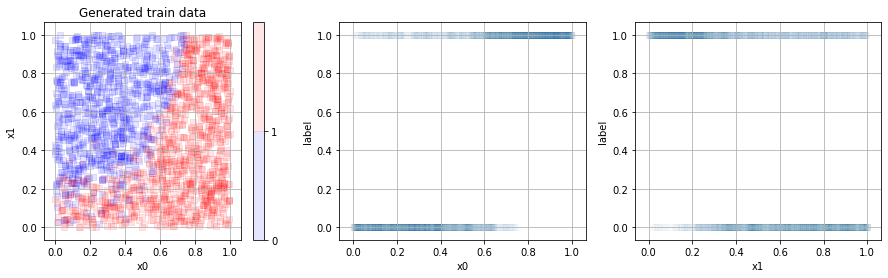

In [3]:
N = 2000
# x has 1 dim in R, label has 1 dim in B
xTrain, labelTrain = generateBatch(N)

colors = ['blue','red']

fig = plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.scatter(xTrain[:,0], xTrain[:,1], c=labelTrain, cmap=pltcolors.ListedColormap(colors), marker=',', alpha=0.1)
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Generated train data')
plt.grid()
cb = plt.colorbar()
loc = np.arange(0,1,1/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels([0,1])
plt.subplot(1,3,2)
plt.scatter(xTrain[:,0], labelTrain, marker=',', alpha=0.01)
plt.xlabel('x0')
plt.ylabel('label')
plt.grid()
plt.subplot(1,3,3)
plt.scatter(xTrain[:,1], labelTrain, marker=',', alpha=0.01)
plt.xlabel('x1')
plt.ylabel('label')
plt.grid()

Bernouilli parameter of the distribution: 0.5135


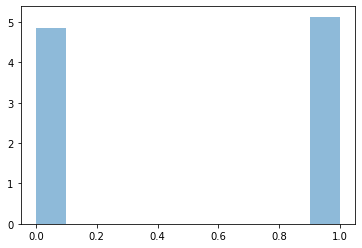

In [4]:
count, bins, ignored = plt.hist(labelTrain*1.0, 10, density=True, alpha=0.5)
p = np.mean(labelTrain)
print('Bernouilli parameter of the distribution:', p)

### Test data for verification of the model

In [5]:
xTest, labelTest = generateBatch(N)
testColors = ['navy', 'orangered']

# K Nearest Neighbors (KNN)



References:
- https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm
- https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/


## Homemade

Using a simple algorithm.

Unweighted : each of the K neighbors has the same weight

In [6]:
# Select a K
k = 10
# Create a Panda dataframe in order to link x and y
df = pd.DataFrame(np.concatenate((xTrain, labelTrain.reshape(-1,1)), axis=1), columns = ('x0', 'x1', 'label'))
# Insert columns to compute the difference of current test to the train and the L2
df.insert(df.shape[1], 'diff0', 0)
df.insert(df.shape[1], 'diff1', 0)
df.insert(df.shape[1], 'L2', 0)
#
threshold = k / 2
labelEst0 = np.zeros(xTest.shape[0])
for i, x in enumerate(xTest):
    # Compute distance and norm to each training sample
    df['diff0'] = df['x0'] - x[0]
    df['diff1'] = df['x1'] - x[1]
    df['L2'] = df['diff0']**2 + df['diff1']**2
    # Get the K lowest
    kSmallest = df.nsmallest(k, 'L2')
    # Finalize prediction based on the mean
    labelEst0[i] = np.sum(kSmallest['label']) > threshold

### Performance of homemade model

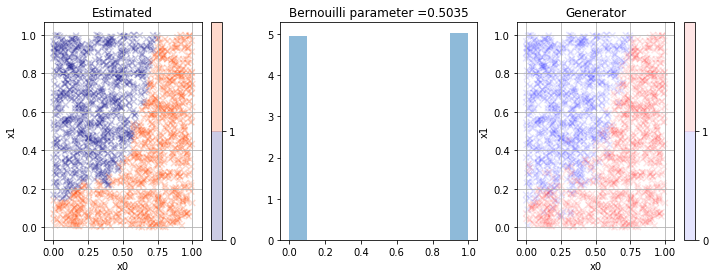

In [7]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.scatter(xTest[:,0], xTest[:,1], c=labelEst0, cmap=pltcolors.ListedColormap(testColors), marker='x', alpha=0.2);
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid()
plt.title('Estimated')
cb = plt.colorbar()
loc = np.arange(0,1,1./len(testColors))
cb.set_ticks(loc)
cb.set_ticklabels([0,1]);
plt.subplot(1,3,2)
plt.hist(labelEst0, 10, density=True, alpha=0.5)
plt.title('Bernouilli parameter =' + str(np.mean(labelEst0)))
plt.subplot(1,3,3)
plt.scatter(xTest[:,0], xTest[:,1], c=labelTest, cmap=pltcolors.ListedColormap(colors), marker='x', alpha=0.1);
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid()
plt.title('Generator')
cb = plt.colorbar()
loc = np.arange(0,1,1./len(colors))
cb.set_ticks(loc)
cb.set_ticklabels([0,1]);

In [8]:
accuracy0 = np.sum(labelTest == labelEst0)/N
print('Accuracy =', accuracy0)

Accuracy = 0.9455


### Precision 
$p(y = 1 \mid \hat{y} = 1)$

In [9]:
print('Precision =', np.sum(labelTest[labelEst0 == 1])/np.sum(labelEst0))

Precision = 0.9433962264150944


### Recall
$p(\hat{y} = 1 \mid y = 1)$

In [10]:
print('Recall =', np.sum(labelTest[labelEst0 == 1])/np.sum(labelTest))

Recall = 0.9481037924151696


### Confusion matrix

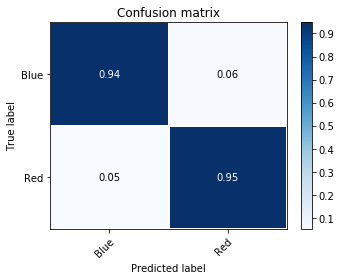

In [11]:
plot_heat_map(skMetrics.confusion_matrix(labelTest, labelEst0), np.array(['Blue', 'Red']), normalize=True);

In [12]:
print(skMetrics.classification_report(labelTest, labelEst0))

              precision    recall  f1-score   support

       False       0.95      0.94      0.95       998
        True       0.94      0.95      0.95      1002

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000



This non-parametric model has a the best performance of all models used so far, including the neural network with two layers.

The large drawback is the amount of computation for each sample to predict. 
This method is hardly usable for sample sizes over 10k.

# Using SciKit Learn

References:
- SciKit documentation
- https://stackabuse.com/k-nearest-neighbors-algorithm-in-python-and-scikit-learn/

In [13]:
model1 = SkKNeighborsClassifier(n_neighbors=k)
model1.fit(xTrain, labelTrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [14]:
labelEst1 = model1.predict(xTest)
print('Accuracy =', model1.score(xTest, labelTest))

Accuracy = 0.9455


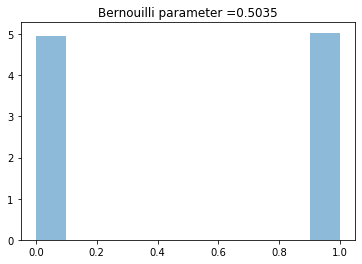

In [15]:
plt.hist(labelEst1*1.0, 10, density=True, alpha=0.5)
plt.title('Bernouilli parameter =' + str(np.mean(labelEst1)));

### Confusion matrix (plot)

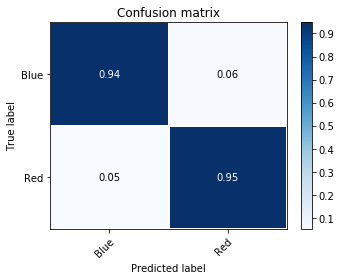

In [16]:
plot_heat_map(skMetrics.confusion_matrix(labelTest, labelEst1), np.array(['Blue', 'Red']), normalize=True);

### Classification report

In [17]:
print(skMetrics.classification_report(labelTest, labelEst1))

              precision    recall  f1-score   support

       False       0.95      0.94      0.95       998
        True       0.94      0.95      0.95      1002

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000



### ROC curve

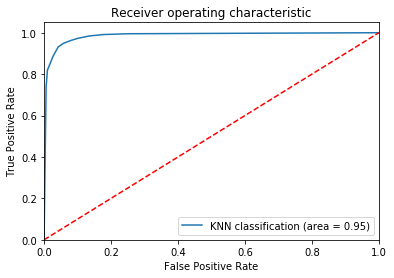

In [18]:
logit_roc_auc = skMetrics.roc_auc_score(labelTest, labelEst1)
fpr, tpr, thresholds = skMetrics.roc_curve(labelTest, model1.predict_proba(xTest)[:,1])
plt.plot(fpr, tpr, label='KNN classification (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right");

# Where to go from here ?

- Other linear implementations and simple neural nets using "raw" Python or SciKit Learn([HTML](ClassificationContinuous2Features.html) / [Jupyter](ClassificationContinuous2Features.ipynb)), using TensorFlow([HTML](ClassificationContinuous2Features-TensorFlow.html) / [Jupyter](ClassificationContinuous2Features-TensorFlow.ipynb)), or using Keras ([HTML](ClassificationContinuous2Features-Keras.html)/ [Jupyter](ClassificationContinuous2Features-Keras.ipynb))

- Non linear problem solving with Support Vector Machine (SVM) ([HTML](ClassificationSVM.html) / [Jupyter](ClassificationSVM.ipynb))
- More complex multi-class models on the Czech and Norways flags using Keras([HTML](ClassificationMulti2Features-Keras.html) / [Jupyter](ClassificationMulti2Features-Keras.ipynb)), showing one of the main motivations to neural networks.

- Compare with the two feature linear regression using simple algorithms ([HTML](../linear/LinearRegressionBivariate.html) / [Jupyter](LinearRegressionBivariate.ipynb])), or using Keras ([HTML](LinearRegressionBivariate-Keras.html) / [Jupyter](LinearRegressionUnivariate-Keras.ipynb))